# 0. Libraries import

In [1]:
import numpy as np
import timeit
from tqdm import tqdm
import networkx as nx
from scipy.sparse import dok_matrix,csr_matrix
import collections
import matplotlib.pyplot as plt

Check that we are using the intel python distribution

In [2]:
!which python

/home/mrcharles/anaconda3/envs/tensorflow/bin/python


# 1. Numba class creation

In [3]:
from numba import jitclass,njit,jit
from numba import int64, float64
from numba import prange

In [4]:
spec = [
    ('size',int64),
    ('alpha',float64[:])
]


#for some strange reason np.random.dirichlet is not compatible with numba
#in the following I define a new just in time class used to sample a dirichlet by normalizing
#a vector of gammas

@jitclass(spec)
class Dirichlet(object):
    
    def __init__(self, size=10, alpha=0.1):
        self.size = size
        self.alpha = np.ones(self.size) * alpha
       
    def sample(self):
        
        dirichlet = np.zeros(self.size,dtype=np.float64)

        #prange comes from numba and allows to parallelize the cycle
        for i in prange(self.size):
            
            #draw the gamma for each component
            dirichlet[i] = np.random.gamma(1,self.alpha[i])
        
        #normalize each component
        dirichlet = dirichlet/np.sum(dirichlet)
        
        #due to numerical instablity we set the first component as a residual in order
        #to make the vector sum to 1
        dirichlet[0] += (1- np.sum(dirichlet))
        
        return dirichlet
        
        
        
    def update(self,indexes,step):
        
        #method used in order to make more likely a future draw from a given node
        #indexes should be a tuple conatining the indexes of the linked edges
        
        self.alpha[indexes[0]] += step
        self.alpha[indexes[1]] += step

        
        
spec2 = [
    ('size',int64),
    ('pdist',float64[:])
]
       
        
#We also define a multinomial class in order to draw the edges to link according to the prob distr
#sampled from the dirichlet
@jitclass(spec2)
class Multinomial(object):
    
    def __init__(self, size=1, pdist=np.ones):
        self.pdist = pdist/len(pdist)
        self.size = size
    
    
    def sample(self):
        
        #we draw from a multinomial and we extract the non 0 index, corresponding to the node to link
        draw1 = np.random.multinomial(n=self.size,pvals=self.pdist)
        draw1 = np.argwhere(draw1)[0][0]
        
        
        draw2 = np.random.multinomial(n=self.size,pvals=self.pdist)
        draw2 = np.argwhere(draw2)[0][0]
        

        return (draw1,draw2)
    
    def set_pvals(self,pdist):
        
        #used to set the prob dist drawn from the dirichlet
        self.pdist = pdist

# 2. Graph creation

In [5]:
###creating sparse adjacency matrix
#this box runs fast, could be made faster by using numba
############## Family creation ##############################

pop_size = 60000 

#me define the initial matrix using the dok format. This allows
#to add the edges relative to the family in an iterative way
adjacency = dok_matrix((pop_size,pop_size),dtype=np.bool)


#we stop when the pop size reaches the desired dimension
i=0
while i <pop_size:
    
    #we start by drawing the dimension of the population from a poisson distribution
    family_size = max(1,np.random.poisson(lam=2))
    
    
    try:
        
        #we use a double cycle to connect each member of the family to everyone else in the family
        for k in range(family_size):

            for j in range(family_size):

                adjacency[i+k,i+j] = 1

        i = i+family_size
    
    
    
    #except used in order to add the last family
    except:
        
        
        remainder_size = pop_size - i
        
        for k in range(remainder_size):

            for j in range(remainder_size):

                adjacency[i+k,i+j] = 1

        i=pop_size

In [6]:
@jit(nopython=True,parallel=True)
def faster_link_sampling(adjacency,links_to_add,dir_sampler,multi_sampler):
    
    for i in prange(links_to_add):
        
        #extract the prob dist from the dirichlet
        pdist = dir_sampler.sample()
        
        #use the sampled distrib to draw the node indexes to connect
        multi_sampler.set_pvals(pdist)
        
        #extract the two indeces of the graph
        vertex_a,vertex_b = multi_sampler.sample()
        
        #we don't want to add self loops
        if(vertex_a != vertex_b):
        
            #add the link in the adj matrix (both ways)
            adjacency[vertex_a,vertex_b] = True
            adjacency[vertex_b,vertex_a] = True
            
            #update weights on extracted vertices in order to make new connections more likely
            dir_sampler.update((vertex_a,vertex_b),0.1)  
        
    return adjacency

In [7]:
####initial values for faster_link sampling

#initializing the dirichlet sampler
dir_sampler = Dirichlet(size=pop_size,alpha=1)

#first distribution coming from the dirichlet sampler
pdist = dir_sampler.sample()

#define the multinomial sampler
multi_sampler = Multinomial(size=1,pdist=pdist)

#number of link to add with the rich gets richer dynamics
links_to_add = pop_size*3

In [8]:
#we define a a matrix with the same shape and data type of the one generated for the familes
adjacency_zeros = np.zeros((pop_size,pop_size),dtype=np.bool)
adjacency_zeros

#old command to define the link matrix
#adjacency_zeros = np.zeros_like(adjacency.todense())

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [9]:
#note that in order to make use of just in time compilation the numba function has to be called once
#below we call it for the first time in order to take advantage of compilation speed up
faster_link_sampling(adjacency_zeros,1,dir_sampler,multi_sampler)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [10]:
#%timeit faster_link_sampling(adjacency_zeros,60000,dir_sampler,multi_sampler)

In [11]:
#the function directly modifies the adjacency matrix passed
faster_link_sampling(adjacency_zeros,links_to_add,dir_sampler,multi_sampler)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [14]:
#we convert the dense matrix into a sparse one
links_to_add = csr_matrix(adjacency_zeros)

In [15]:
adjacency

<60000x60000 sparse matrix of type '<class 'numpy.bool_'>'
	with 171494 stored elements in Dictionary Of Keys format>

In [16]:
links_to_add

<60000x60000 sparse matrix of type '<class 'numpy.bool_'>'
	with 339884 stored elements in Compressed Sparse Row format>

In [17]:
#since the sparse matrix are defined as booleans, we can add the links to family matrix
#just by summing the two matrices and taking advatage of boolean algebra
adjacency = adjacency+links_to_add

In [18]:
adjacency

<60000x60000 sparse matrix of type '<class 'numpy.bool_'>'
	with 511368 stored elements in Compressed Sparse Column format>

# 3. Graph diagnostics

In [22]:
G = nx.from_scipy_sparse_matrix(adjacency)

In [23]:
nx.is_connected(G)

False

In [24]:
nx.number_connected_components(G)

153

In [29]:
#component dimension, we print the dimensions of the five largest components
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)][:5]

[59844, 3, 2, 2, 1]

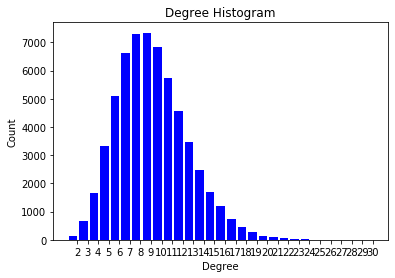

In [27]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg);

# Experimenting with dask (roba a caso)

In [5]:
from dask import array as ar
import sparse
import numpy as np

In [11]:
x = ar.random.binomial(1,p=0.0001,size=(100000,100000)).map_blocks(sparse.COO).astype(np.bool, copy=True)

In [12]:
x.compute()

Format,coo
Data Type,bool
Shape,"(100000, 100000)"
nnz,1001066
Density,0.0001001066
Read-only,True
Size,16.2M
Storage ratio,0.0


In [13]:
y = ar.random.binomial(1,p=0.0001,size=(100000,100000)).map_blocks(sparse.COO).astype(np.bool, copy=True)

In [14]:
y.compute()

Format,coo
Data Type,bool
Shape,"(100000, 100000)"
nnz,1000776
Density,0.0001000776
Read-only,True
Size,16.2M
Storage ratio,0.0


In [17]:
x+y.compute()

dask.array<add, shape=(100000, 100000), dtype=bool, chunksize=(4000, 4000), chunktype=sparse.COO>